In [1]:
#yahoo finance as data source
#!pip install yfinance
import yfinance as yf

In [2]:
#See the yahoo finance ticker for your stock symbol
stock_symbol = 'BTC-USD'
start_date = '2018-04-01'
end_date = '2023-03-31'

In [3]:
#last 5 financial year data with interval of 1 day
data = yf.download(tickers=stock_symbol,start=start_date, end=end_date,interval='1d')

[*********************100%***********************]  1 of 1 completed


In [4]:
type(data)

pandas.core.frame.DataFrame

In [5]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-04-01,7003.060059,7060.950195,6526.870117,6844.229980,6844.229980,4532100096
2018-04-02,6844.859863,7135.470215,6816.580078,7083.799805,7083.799805,4333440000
2018-04-03,7102.259766,7530.939941,7072.490234,7456.109863,7456.109863,5499700224
2018-04-04,7456.410156,7469.879883,6803.879883,6853.839844,6853.839844,4936000000
2018-04-05,6848.649902,6933.819824,6644.799805,6811.470215,6811.470215,5639320064


In [6]:
len(data)

1825

In [7]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-26,27495.523438,28178.144531,27445.046875,27994.330078,27994.330078,13878363192
2023-03-27,27994.068359,28037.925781,26606.689453,27139.888672,27139.888672,18188895178
2023-03-28,27132.888672,27460.718750,26677.818359,27268.130859,27268.130859,17783600385
2023-03-29,27267.031250,28619.542969,27259.662109,28348.441406,28348.441406,20684945906
2023-03-30,28350.140625,29159.902344,27720.160156,28033.562500,28033.562500,22435349951


In [8]:
opn = data[['Open']]

<AxesSubplot:xlabel='Date'>

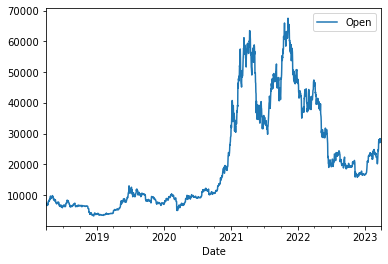

In [9]:
opn.plot()

In [10]:
import matplotlib.pyplot as plt

In [11]:
ds = opn.values

In [12]:
ds

array([[ 7003.06005859],
       [ 6844.85986328],
       [ 7102.25976562],
       ...,
       [27132.88867188],
       [27267.03125   ],
       [28350.140625  ]])

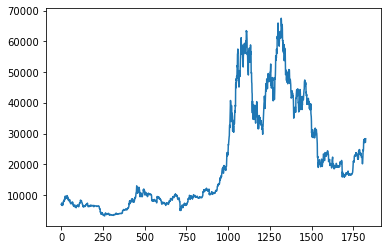

In [13]:
plt.plot(ds)

In [14]:
import numpy as np

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [17]:
len(ds_scaled), len(ds)

(1825, 1825)

In [18]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [19]:
train_size,test_size

(1277, 548)

In [20]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [21]:
len(ds_train),len(ds_test)

(1277, 548)

In [22]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [23]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [24]:
X_train.shape,y_train.shape

((1176, 100), (1176,))

In [25]:
X_test.shape, y_test.shape

((447, 100), (447,))

In [26]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [27]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [28]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [29]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
19/19 [==============================] - 10s 300ms/step - loss: 0.0186 - val_loss: 0.0087
Epoch 2/100
19/19 [==============================] - 3s 177ms/step - loss: 0.0032 - val_loss: 0.0074
Epoch 3/100
19/19 [==============================] - 4s 241ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 4/100
19/19 [==============================] - 4s 197ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 5/100
19/19 [==============================] - 3s 174ms/step - loss: 0.0018 - val_loss: 0.0041
Epoch 6/100
19/19 [==============================] - 4s 234ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 7/100
19/19 [==============================] - 4s 194ms/step - loss: 0.0017 - val_loss: 0.0044
Epoch 8/100
19/19 [==============================] - 4s 221ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 9/100
19/19 [==============================] - 5s 283ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 10/100
19/19 [==============================] - 4s 234ms/step - loss: 0.0013 - val_l

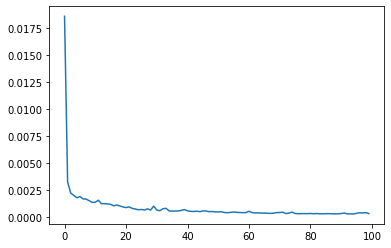

In [30]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [31]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

14/14 [==============================] - 0s 28ms/step


In [32]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

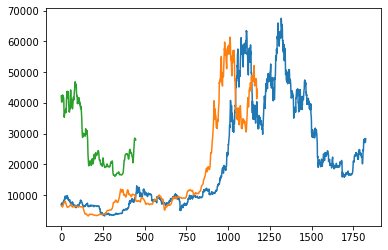

In [33]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [34]:
type(train_predict)

numpy.ndarray

In [35]:
test = np.vstack((train_predict,test_predict))

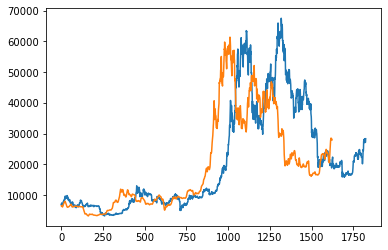

In [36]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [37]:
len(ds_test)

548

In [38]:
#Getting the last 100 days records
fut_inp = ds_test[448:]

In [39]:
fut_inp = fut_inp.reshape(1,-1)

In [40]:
tmp_inp = list(fut_inp)

In [41]:
fut_inp.shape

(1, 100)

In [42]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [43]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.38497960567474365], [0.3877080976963043], [0.38911452889442444], [0.38970232009887695], [0.389749675989151], [0.38945508003234863], [0.3889945149421692], [0.38851892948150635], [0.38814353942871094], [0.38794466853141785], [0.3879646062850952], [0.38821932673454285], [0.3887084424495697], [0.3894233703613281], [0.3903522789478302], [0.3914848864078522], [0.3928128182888031], [0.3943300247192383], [0.39603185653686523], [0.39791348576545715], [0.3999687135219574], [0.4021894335746765], [0.40456435084342957], [0.40707945823669434], [0.4097180962562561], [0.41246122121810913], [0.4152880907058716], [0.41817688941955566], [0.42110592126846313], [0.42405298352241516]]


In [44]:
len(ds_scaled)

1825

In [45]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

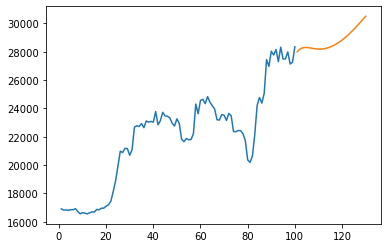

In [46]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[1725:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [47]:
ds_new = ds_scaled.tolist()

In [48]:
len(ds_new)

1825

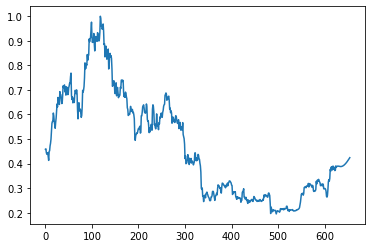

In [49]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [50]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

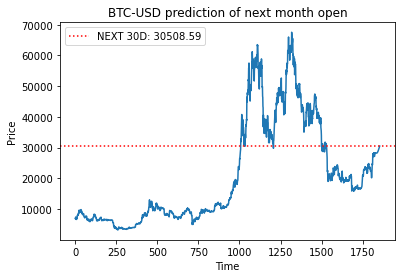

In [51]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

